## start here

In [3]:
from model import atp_graph, losses
from data_wrangler import synthetic_data_gen, feature_extractor, dataset_preparer
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from model import atp_pipeline
import argparse
from Tutorials.helper import batcher
import os

In [19]:
x_train, y_train, x_val, y_val, x_test, y_test = dataset_preparer.weather_processor(path_to_weather_data="datasets/weather.csv") 
save_dir = "weights/forecasting/ETT/atp"
    

In [20]:
n_C = 100
n_T = 100

opt = tf.keras.optimizers.Adam(3e-4)
batch_size = 32

In [21]:
from model import atp_pipeline
from comparison_models.tnp import tnp_pipeline
import argparse
from Tutorials.helper import batcher

## Training

In [22]:
import matplotlib.pyplot as plt

In [23]:
train_loglik = []
val_loglik = []



In [24]:
step = 1
run= 51 + 0
tf.random.set_seed(run)
atp_model = atp_pipeline.instantiate_atp("ETT")
tr_step = atp_graph.build_graph()
name_comp = 'run_' + str(run)
folder = save_dir + '/ckpt/check_' + name_comp
if not os.path.exists(folder): os.mkdir(folder)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=atp_model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 
sum_mse_tot = 0; sum_nll_tot = 0
mini = 50000
opt = tf.keras.optimizers.Adam(3e-4)


In [25]:
%%time

for i in range(5000):
    idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
    x,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T) ####### generalise for not weather
    _,_, nll_pp_tr , _ = tr_step(atp_model, opt, x,y,n_C,n_T, training=True)

    if i % 100 == 0:
        
        train_loglik.append(nll_pp_tr)
        
        
        idx_list = list(range(x_val.shape[0]- (n_C+n_T)))
        t_te,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
        μ, log_σ = atp_model([t_te, y_te, n_C, n_T, False])
        _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
        
        val_loglik.append(nll_pp_te)
        
        plt.plot(train_loglik)
        plt.plot(val_loglik)
        print(nll_pp_te)
        print(min(val_loglik))
        plt.show()

(32, 100, None, 1)
(32, 100, None, 1)


TypeError: in user code:

    File "/Users/omernivron/Documents/ATP/model/atp_graph.py", line 13, in train_step  *
        μ, log_σ = atp_model([x, y, n_C, n_T, training])
    File "/Users/omernivron/miniforge3/envs/tf_m1_n/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer "atp_pipeline_2" (type atp_pipeline).
    
    in user code:
    
        File "/Users/omernivron/Documents/ATP/model/atp_pipeline.py", line 51, in call  *
            y_diff, x_diff, d, x_n, y_n = self._DE([y, x, n_C, n_T, training])
        File "/Users/omernivron/miniforge3/envs/tf_m1_n/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        TypeError: Exception encountered when calling layer "de_2" (type DE).
        
        in user code:
        
            File "/Users/omernivron/Documents/ATP/data_wrangler/feature_extractor.py", line 80, in call  *
                y_diff,  x_diff,  d,  x_n,  y_n = self.derivative_function([y,  x,  n_C,  n_T])
            File "/Users/omernivron/Documents/ATP/data_wrangler/feature_extractor.py", line 164, in derivative_function  *
                ix = tf.argsort(tf.cast(tf.math.reduce_euclidean_norm((current_x - x_temp),
        
            TypeError: Input 'y' of 'AddV2' Op has type int32 that does not match type float32 of argument 'x'.
        
        
        Call arguments received:
          • inputs=['tf.Tensor(shape=(32, None, 1), dtype=float32)', 'tf.Tensor(shape=(32, None, 1), dtype=float32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=bool)']
    
    
    Call arguments received:
      • inputs=['tf.Tensor(shape=(32, 200, 1), dtype=float32)', 'tf.Tensor(shape=(32, 200, 1), dtype=float32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=bool)']


In [27]:
test_batch_s = 100

idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
num_batches = x_test.shape[0]//test_batch_s

for _ in range(num_batches): #### specify correct number of batches for the batcher #####
    if(_ == (num_batches-1)): test_batch_s = len(idx_list)    
    print(len(idx_list))
    print(test_batch_s)
    t_te,y_te,idx_list = batcher(x_test, y_test, idx_list,batch_s = test_batch_s, window=n_C+n_T)
    μ, log_σ = atp_model([t_te, y_te, n_C, n_T, False])
    _, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
    sum_nll_tot += sum_nll / n_T
    sum_mse_tot += sum_mse / n_T

nllx =  sum_nll_tot / (test_batch_s * x_test.shape[0]//test_batch_s)
msex =  sum_mse_tot / (test_batch_s * x_test.shape[0]//test_batch_s)


nll_list.append(nllx.numpy())
mse_list.append(msex.numpy())

#     np.save(save_dir + '/nll_list.npy', nll_list)    
#     np.save(save_dir + '/mse_list.npy', mse_list)  

10340
100
10240
100
10140
100
10040
100
9940
100
9840
100
9740
100
9640
100
9540
100
9440
100
9340
100
9240
100
9140
100
9040
100
8940
100
8840
100
8740
100
8640
100
8540
100
8440
100
8340
100
8240
100
8140
100
8040
100
7940
100
7840
100
7740
100
7640
100
7540
100
7440
100
7340
100
7240
100
7140
100
7040
100
6940
100
6840
100
6740
100
6640
100
6540
100
6440
100
6340
100
6240
100
6140
100
6040
100
5940
100
5840
100
5740
100
5640
100
5540
100
5440
100
5340
100
5240
100
5140
100
5040
100
4940
100
4840
100
4740
100
4640
100
4540
100
4440
100
4340
100
4240
100
4140
100
4040
100
3940
100
3840
100
3740
100
3640
100
3540
100
3440
100
3340
100
3240
100
3140
100
3040
100
2940
100
2840
100
2740
100
2640
100
2540
100
2440
100
2340
100
2240
100
2140
100
2040
100
1940
100
1840
100
1740
100
1640
100
1540
100
1440
100
1340
100
1240
100
1140
100
1040
100
940
100
840
100
740
100
640
100
540
100
440
100
340
100
240
100
140
100
40
100


ValueError: Cannot take a larger sample than population when 'replace=False'

In [31]:
nllx =  sum_nll_tot / (test_batch_s * x_test.shape[0]//test_batch_s)
msex =  sum_mse_tot / (test_batch_s * x_test.shape[0]//test_batch_s)


In [30]:
nllx

<tf.Tensor: shape=(), dtype=float32, numpy=0.19502912>

In [32]:
msex

<tf.Tensor: shape=(), dtype=float32, numpy=0.030019429>

In [56]:
test_batch_s = 100

idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
num_batches = x_test.shape[0]//test_batch_s

for _ in range(num_batches): #### specify correct number of batches for the batcher #####
    if(_ == (num_batches-1)): test_batch_s = len(idx_list)    
    print(len(idx_list))
    print(test_batch_s)
    t_te,y_te,idx_list = batcher(x_test, y_test, idx_list,batch_s = test_batch_s, window=n_C+n_T)

    mean_prediction = np.mean(y_te[:,:n_C],axis=1)
    mean_prediction_repeat = np.repeat(mean_prediction[np.newaxis,:,:],axis=0,repeats=100)    
    
    mse = np.sum((mean_prediction - y_te[:,n_C:n_C+n_T])**2)
    
    sum_mse_tot += mse / n_T

10340
100
10240
100
10140
100
10040
100
9940
100
9840
100
9740
100
9640
100
9540
100
9440
100
9340
100
9240
100
9140
100
9040
100
8940
100
8840
100
8740
100
8640
100
8540
100
8440
100
8340
100
8240
100
8140
100
8040
100
7940
100
7840
100
7740
100
7640
100
7540
100
7440
100
7340
100
7240
100
7140
100
7040
100
6940
100
6840
100
6740
100
6640
100
6540
100
6440
100
6340
100
6240
100
6140
100
6040
100
5940
100
5840
100
5740
100
5640
100
5540
100
5440
100
5340
100
5240
100
5140
100
5040
100
4940
100
4840
100
4740
100
4640
100
4540
100
4440
100
4340
100
4240
100
4140
100
4040
100
3940
100
3840
100
3740
100
3640
100
3540
100
3440
100
3340
100
3240
100
3140
100
3040
100
2940
100
2840
100
2740
100
2640
100
2540
100
2440
100
2340
100
2240
100
2140
100
2040
100
1940
100
1840
100
1740
100
1640
100
1540
100
1440
100
1340
100
1240
100
1140
100
1040
100
940
100
840
100
740
100
640
100
540
100
440
100
340
100
240
100
140
100
40
100


ValueError: Cannot take a larger sample than population when 'replace=False'

In [57]:
msex =  sum_mse_tot / (test_batch_s * x_test.shape[0]//test_batch_s)
print(msex)

tf.Tensor(0.8527205, shape=(), dtype=float32)


In [18]:
print(min(val_loglik))

tf.Tensor(-0.59912556, shape=(), dtype=float32)


In [10]:
atp_model.summary()

Model: "atp_pipeline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_wrapper (feature_wr  multiple                 0         
 apper)                                                          
                                                                 
 atp (ATP)                   multiple                  76562     
                                                                 
 de (DE)                     multiple                  4         
                                                                 
Total params: 76,566
Trainable params: 76,564
Non-trainable params: 2
_________________________________________________________________


In [14]:
y_train.shape

(36887, 1, 1)

In [15]:
y.shape

(32, 200, 1)

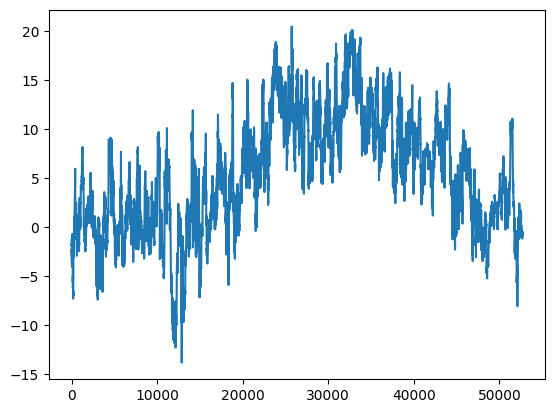

In [34]:
plt.plot(data[:,4:5].astype("float32")[:])

## TNP

In [ ]:
### set this up for training and saving best models adn then loading it and calculating loglik.

In [9]:
model.summary()

Model: "tnp_pipeline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_wrapper (feature_wr  multiple                 0 (unused)
 apper)                                                          
                                                                 
 tnp__decoder (TNP_Decoder)  multiple                  87450     
                                                                 
Total params: 87,450
Trainable params: 87,450
Non-trainable params: 0
_________________________________________________________________


In [7]:
step = 1
run= 49 + 0
tf.random.set_seed(run)
model = tnp_pipeline.instantiate_tnp("weather")
tr_step = atp_graph.build_graph()

name_comp = 'run_' + str(run)
folder = save_dir + '/ckpt/check_' + name_comp
if not os.path.exists(folder): os.mkdir(folder)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 
sum_mse_tot = 0; sum_nll_tot = 0
mini = 50000
opt = tf.keras.optimizers.Adam(3e-4)



2023-05-03 17:51:36.124626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-05-03 17:51:36.241643: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f4bc521f400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-03 17:51:36.241703: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2023-05-03 17:51:36.246396: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-03 17:51:36.662247: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


tf.Tensor(0.6671719, shape=(), dtype=float32)
tf.Tensor(0.6671719, shape=(), dtype=float32)


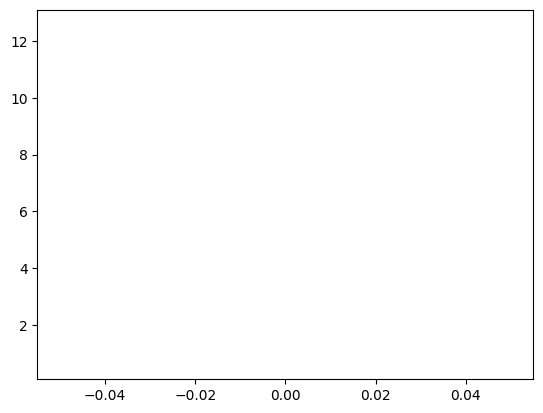

tf.Tensor(0.63576925, shape=(), dtype=float32)
tf.Tensor(0.63576925, shape=(), dtype=float32)


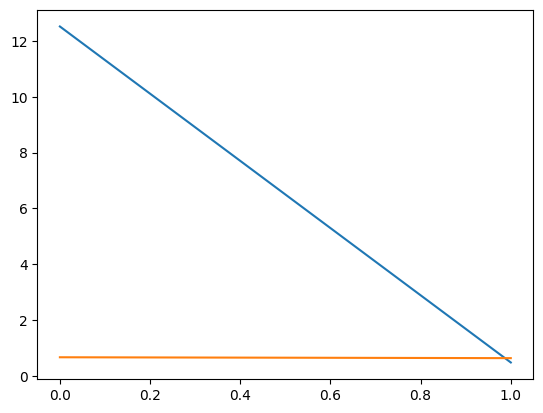

tf.Tensor(-0.04432409, shape=(), dtype=float32)
tf.Tensor(-0.04432409, shape=(), dtype=float32)


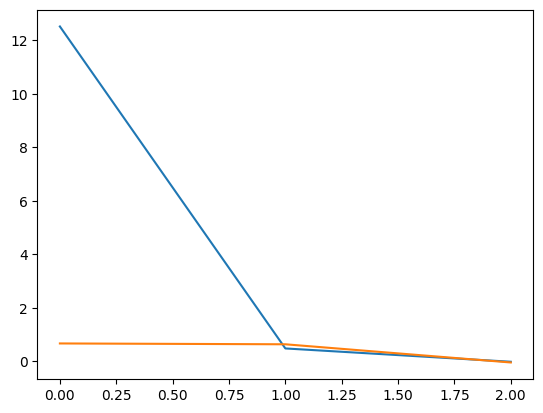

tf.Tensor(0.033502664, shape=(), dtype=float32)
tf.Tensor(-0.04432409, shape=(), dtype=float32)


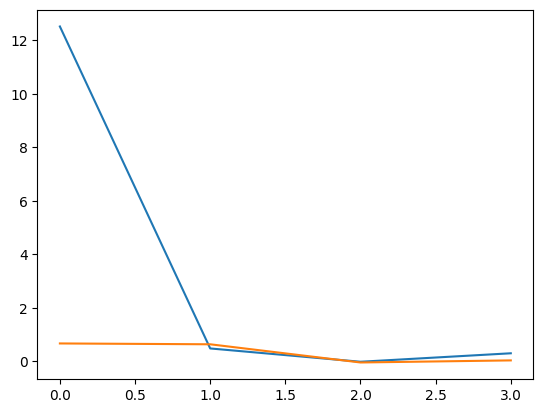

tf.Tensor(0.009663195, shape=(), dtype=float32)
tf.Tensor(-0.04432409, shape=(), dtype=float32)


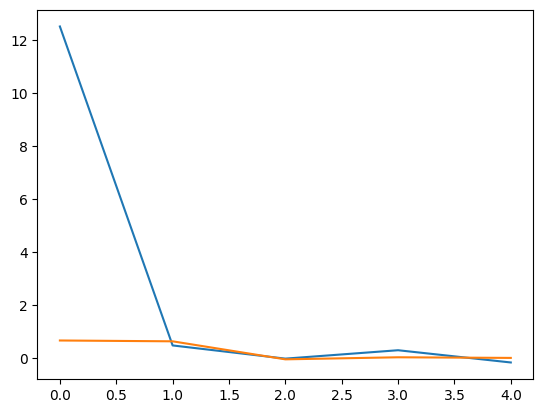

tf.Tensor(-0.04248213, shape=(), dtype=float32)
tf.Tensor(-0.04432409, shape=(), dtype=float32)


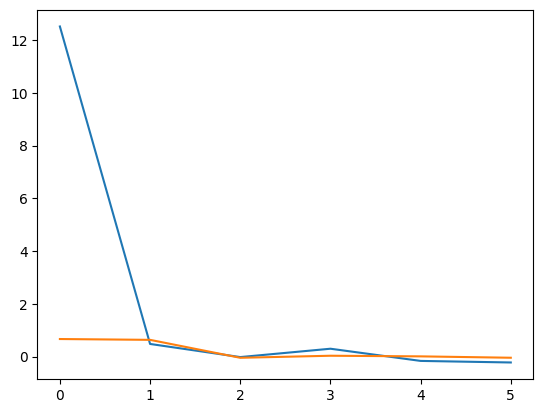

tf.Tensor(-0.04299256, shape=(), dtype=float32)
tf.Tensor(-0.04432409, shape=(), dtype=float32)


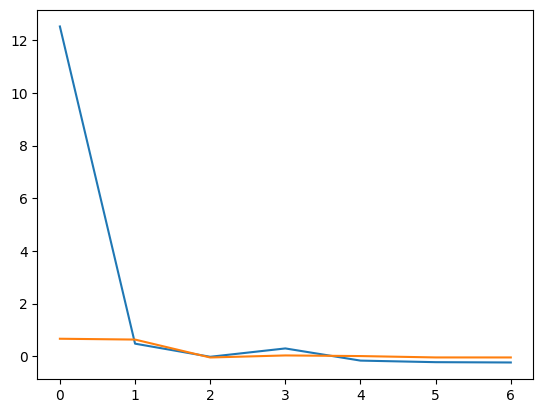

tf.Tensor(-0.21960557, shape=(), dtype=float32)
tf.Tensor(-0.21960557, shape=(), dtype=float32)


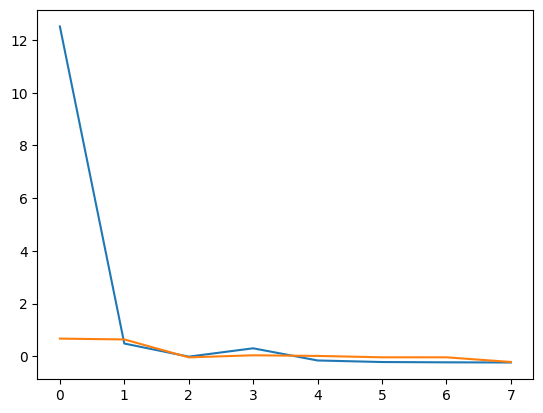

tf.Tensor(0.014853839, shape=(), dtype=float32)
tf.Tensor(-0.21960557, shape=(), dtype=float32)


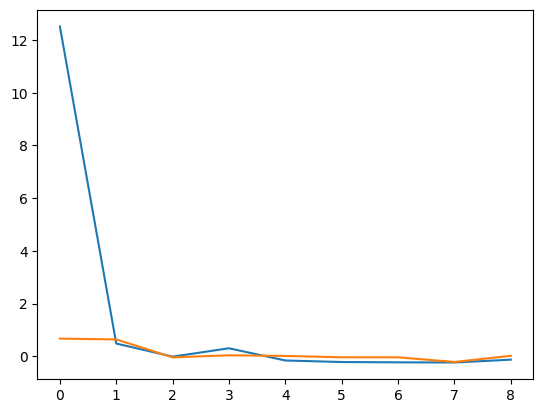

tf.Tensor(-0.10246849, shape=(), dtype=float32)
tf.Tensor(-0.21960557, shape=(), dtype=float32)


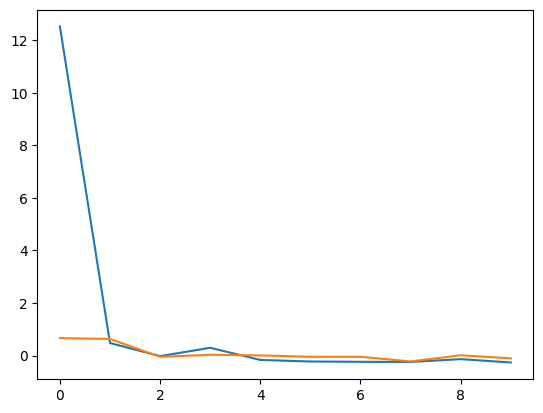

tf.Tensor(-0.06683547, shape=(), dtype=float32)
tf.Tensor(-0.21960557, shape=(), dtype=float32)


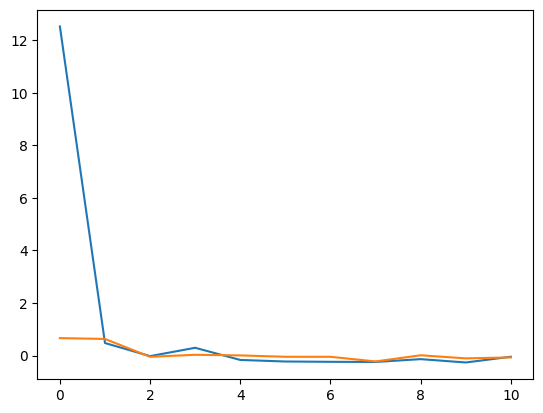

tf.Tensor(-0.15172727, shape=(), dtype=float32)
tf.Tensor(-0.21960557, shape=(), dtype=float32)


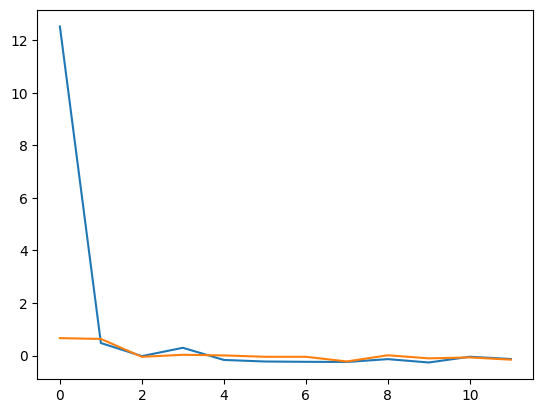


KeyboardInterrupt



In [8]:
%%time

for i in range(5000):
    idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
    x,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T) ####### generalise for not weather
    _,_, nll_pp_tr , _ = tr_step(model, opt, x,y,n_C,n_T, training=True)

    if i % 100 == 0:
        
        train_loglik.append(nll_pp_tr)
        
        
       
        idx_list = list(range(x_val.shape[0]- (n_C+n_T)))
        t_te,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
        μ, log_σ = model([t_te, y_te, n_C, n_T, False])
        _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
        
        val_loglik.append(nll_pp_te)
        
        plt.plot(train_loglik)
        plt.plot(val_loglik)
        print(nll_pp_te)
        print(min(val_loglik))
        plt.show()

In [16]:
test_batch_s = 100

idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
num_batches = x_test.shape[0]//test_batch_s

for _ in range(num_batches): #### specify correct number of batches for the batcher #####
    if(_ == (num_batches-1)): test_batch_s = len(idx_list)    
    print(len(idx_list))
    print(test_batch_s)
    t_te,y_te,idx_list = batcher(x_test, y_test, idx_list,batch_s = test_batch_s, window=n_C+n_T)
    μ, log_σ = model([t_te, y_te, n_C, n_T, False])
    _, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
    sum_nll_tot += sum_nll / n_T
    sum_mse_tot += sum_mse / n_T

nllx =  sum_nll_tot / (test_batch_s * x_test.shape[0]//test_batch_s)
msex =  sum_mse_tot / (test_batch_s * x_test.shape[0]//test_batch_s)


nll_list.append(nllx.numpy())
mse_list.append(msex.numpy())

#     np.save(save_dir + '/nll_list.npy', nll_list)    
#     np.save(save_dir + '/mse_list.npy', mse_list)  

10340
100
10240
100
10140
100
10040
100
9940
100
9840
100
9740
100
9640
100
9540
100
9440
100
9340
100
9240
100
9140
100
9040
100
8940
100
8840
100
8740
100
8640
100
8540
100
8440
100
8340
100
8240
100
8140
100
8040
100
7940
100
7840
100
7740
100
7640
100
7540
100
7440
100
7340
100
7240
100
7140
100
7040
100
6940
100
6840
100
6740
100
6640
100
6540
100
6440
100
6340
100
6240
100
6140
100
6040
100
5940
100
5840
100
5740
100
5640
100
5540
100
5440
100
5340
100
5240
100
5140
100
5040
100
4940
100
4840
100
4740
100
4640
100
4540
100
4440
100
4340
100
4240
100
4140
100
4040
100
3940
100
3840
100
3740
100
3640
100
3540
100
3440
100
3340
100
3240
100
3140
100
3040
100
2940
100
2840
100
2740
100
2640
100
2540
100
2440
100
2340
100
2240
100
2140
100
2040
100
1940
100
1840
100
1740
100
1640
100
1540
100
1440
100
1340
100
1240
100
1140
100
1040
100
940
100
840
100
740
100
640
100
540
100
440
100
340
100
240
100
140
100
40
100


ValueError: Cannot take a larger sample than population when 'replace=False'

In [17]:
nllx =  sum_nll_tot / (test_batch_s * x_test.shape[0]//test_batch_s)
msex =  sum_mse_tot / (test_batch_s * x_test.shape[0]//test_batch_s)



In [18]:
nllx

<tf.Tensor: shape=(), dtype=float32, numpy=1.307424>